In [7]:
from glob import glob
from collections import defaultdict
import os
import numpy as np
import pretty_midi
import random
from IPython.display import Audio
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns 
import hydra
from hydra.experimental import compose, initialize
from omegaconf import DictConfig, OmegaConf
from IPython.display import display, Math

import src.run_vae as run_vae
import src.run_vqvae as run_vqvae
import src.run_onestep as run_onestep
import src.run_classifier as run_classifier
from src.utils import compute_metrical_mean_std, batch2array, tensor2np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [8,6]
plt.rcParams.update({'font.size': 12})

import torch
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # relevant only for my environment
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

np.random.seed(0)

## Reconstruction metrics

In [12]:
epoch = 0
batch_size = 64
model_type = "vqvae" 
model_name = "vqvae_genrecond0"

prior_model_name = f"prior_genrecond0"
prior_epoch = 10

losses = [] 
all_note_recons, all_vel_recons, all_mt_recons = [], [], []

all_note_orig, all_vel_orig, all_mt_orig = [], [], []
all_note_z, all_vel_z, all_mt_z = [], [], []
all_quantized_z = [] 
all_genre_idxs = [] 


with initialize(config_path=f"../src/outputs/{model_type}/{model_name}/.hydra"):
    cfg = compose(config_name="config")
    # print(OmegaConf.to_yaml(cfg))
    if model_type == "vae" : 
        exp = run_vae.Experiment(cfg, device)
    elif model_type == "vqvae":
        exp = run_vqvae.Experiment(cfg, device)
    elif model_type == "onestep":
        exp = run_onestep.Experiment(cfg, device)
    else :
        print ("BYE")


    # load model 
    if model_type == "onestep": 
        exp.model = torch.load(f"../trained_models/{model_name}/{model_name}_{epoch}.pt").to(device)
    else : 
        exp.all_model = torch.load(f"../trained_models/{model_name}/{model_name}_{epoch}.pt").to(device)

    test_data, test_dataloader = exp.get_test_data(batch_size=batch_size, shuffle=True)


    all_orig, all_recons, skels, all_zs, all_losses, NOTE_F1, VEL_KL, MT_KL, tempos, genre_idxs = exp.run(test_dataloader, return_results=True)


    note_orig, vel_orig, mt_orig = all_orig


    note_recons, vel_recons, mt_recons = all_recons

#         plot_drum_matrix(note_recons[0])

    if model_type == "vae":
        note_zs, vel_zs, mt_zs = all_zs
    elif model_type == "vqvae": 
        note_zs, vel_zs, mt_zs, quantized_idxs = all_zs
    note_loss, vel_loss, mt_loss = all_losses
    print (note_loss, vel_loss, mt_loss, NOTE_F1)
    print (VEL_KL, MT_KL)



    # RECON LOSS 
    losses.append([note_loss, vel_loss, mt_loss, NOTE_F1, VEL_KL, MT_KL])

   
    all_note_recons.extend(note_recons)
    all_vel_recons.extend(vel_recons)
    all_mt_recons.extend(mt_recons)
    all_genre_idxs.extend(genre_idxs)

    all_note_orig.extend(note_orig)
    all_vel_orig.extend(vel_orig)
    all_mt_orig.extend(mt_orig)

    if model_type != "onestep" : 
        all_note_z.extend(note_zs)
        all_vel_z.extend(vel_zs)
        all_mt_z.extend(mt_zs)


    if model_type == "vqvae":
        all_quantized_z.extend(quantized_idxs)



# #         # Random note generation
#         if model_type == "vqvae" : 
#             prior_model = torch.load(f"../trained_models/{prior_model_name}/{prior_model_name}_{prior_epoch}.pt").to(device)
# #             for c in range(64):
# #                 random_outs, random_genre_idxs = exp.generate(test_dataloader, epoch, reconstruct=False, n_samples=2,code_idx=c, fname=f"ALL_{c}", prior_model=prior_model, to_midi=True)
#             random_outs, random_genre_idxs = exp.generate(test_dataloader, epoch, reconstruct=False, n_samples=3, fname="samevel2_random", prior_model=prior_model, to_midi=True)
#         else : 
#             random_outs, random_genre_idxs = exp.generate(test_dataloader, epoch, reconstruct=False, fname="random", n_samples=2, to_midi=True)

    GENRE_LIST = cfg.genre_list
    
    split_number = cfg.split_number

Genre cond: True
Vel cond: False
Time cond: False
Split index: 0


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


1722
ACC 0.33896108774038464
0.2872404524913201 0.0495673012561523 0.01685419395709267 0.49417542005241016
2.34664315422099 1.2670801720785545


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Metrical vel, microtiming plot

In [9]:
all_note_recons_ = np.array(all_note_recons)
print (all_note_recons_.shape)

all_vel_recons_ = np.array(all_vel_recons)

all_mt_recons_ = np.array(all_mt_recons)

all_note_orig_ = np.array(all_note_orig)

all_vel_orig_ = np.array(all_vel_orig)

all_mt_orig_ = np.array(all_mt_orig)

skels = np.array(skels)
print ("skels", skels.shape)

all_genre_idxs_ = np.array(all_genre_idxs)
all_genre_idxs_ = all_genre_idxs_.reshape(-1)
print (all_note_recons_.shape, all_genre_idxs_.shape)

# divide the dataset into genres 
idxs_per_genre = [ []  for _ in range(len(GENRE_LIST))]
for i in range(len(all_genre_idxs_)):
    curr_genre_idx = all_genre_idxs_[i]
    idxs_per_genre[curr_genre_idx].append(i)

(1664, 32, 7)
skels (1664, 32, 7)
(1664, 32, 7) (1664,)


[(0.03195012, 0.027993003), (0.038988926, 0.030132856), (0.038202338, 0.03096174), (0.037632607, 0.029178219)]
[(0.03365901, 0.030547082), (0.029527219, 0.033997003), (0.037582092, 0.033317093), (0.02770707, 0.03238903)]
[(0.053149443, 0.035735767), (0.07345496, 0.038351696), (0.06692098, 0.039446875), (0.072445974, 0.039487626)]
[(0.021990605, 0.020390581), (0.016216194, 0.019863255), (0.01573765, 0.02164741), (0.021311652, 0.014896149)]
[(0.04755697, 0.053439677), (0.053190548, 0.05503934), (0.05558094, 0.0571813), (0.05235753, 0.051276207)]
[(0.053953484, 0.033667613), (0.05402142, 0.030845094), (0.05605422, 0.03403621), (0.05368295, 0.03056287)]


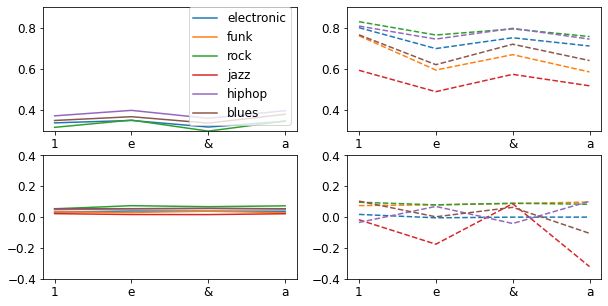

In [10]:
ax1_ylim = (0.3,0.9)
ax2_ylim = (-0.4, 0.4)
# FOR RECON 

fig, axs = plt.subplots(2, 2, figsize=(10,5))

for g in range(len(GENRE_LIST)): 
    vel_recon_metric_list = []
    time_recon_metric_list = []
    
    genre_vel_recon = all_vel_recons_[idxs_per_genre[g]]
    genre_mt_recon = all_mt_recons_[idxs_per_genre[g]]
    genre_note_recon = all_note_recons_[idxs_per_genre[g]]
    
    vel_orig_metric_list = []
    time_orig_metric_list = []
    
    genre_vel_orig = all_vel_orig_[idxs_per_genre[g]]
    genre_mt_orig = all_mt_orig_[idxs_per_genre[g]]
    genre_note_orig = all_note_orig_[idxs_per_genre[g]]
    
    
    for i in range(4):
        vel_m, vel_s = compute_metrical_mean_std(genre_vel_recon, genre_note_recon, i+1)
        vel_recon_metric_list.append((vel_m, vel_s))

        time_m, time_s = compute_metrical_mean_std(genre_mt_recon, genre_note_recon, i+1)
        time_recon_metric_list.append((time_m, time_s))
        
        vel_m, vel_s = compute_metrical_mean_std(genre_vel_orig, genre_note_orig, i+1)
        vel_orig_metric_list.append((vel_m, vel_s))

        time_m, time_s = compute_metrical_mean_std(genre_mt_orig, genre_note_orig, i+1)
        time_orig_metric_list.append((time_m, time_s))
    
    xrange = ["1", "e", "&", "a"]
        

    axs[0,0].plot(xrange, [x[0] for x in vel_recon_metric_list])
    axs[0,1].plot(xrange, [x[0] for x in vel_orig_metric_list], linestyle="--")

    
    axs[1,0].plot(xrange, [x[0] for x in time_recon_metric_list])
    axs[1,1].plot(xrange,[x[0] for x in time_orig_metric_list], linestyle="--")
    print (time_recon_metric_list)

    
axs[0,0].set_ylim(ax1_ylim)
axs[0,1].set_ylim(ax1_ylim)
axs[1,0].set_ylim(ax2_ylim)
axs[1,1].set_ylim(ax2_ylim)
axs[0,0].legend(GENRE_LIST)


## Genre classification

In [11]:
def make_batches(data, batch_size):
    batched_data = []
    n_batches = len(data) // batch_size 
    for i in range(n_batches):
        d = data[i * batch_size : (i+1) * batch_size]
        batched_data.append(d)
    return np.array(batched_data)
test_out = make_batches(all_note_recons_, 64)
print (test_out.shape)

(26, 64, 32, 7)


In [13]:
epoch = 60
batch_size = 64
cls_model_type = "classifier" # vae or vqvae
cls_model_name = f"classifier_split{split_number}"

losses = [] 

with initialize(config_path=f"../src/outputs/{cls_model_type}/{cls_model_name}/.hydra"):
    cfg = compose(config_name="config")
#     print(OmegaConf.to_yaml(cfg))
    exp = run_classifier.Experiment(cfg, device)
    # load model 
    exp.model = torch.load(f"../trained_models/{cls_model_name}/{cls_model_name}_{epoch}.pt").to(device)

    test_data, test_dataloader = exp.get_test_data(batch_size=batch_size)
    loss, acc, orig_prob, orig_label = exp.run(test_dataloader, return_results=True)
    ORIG_GENRE_ACC = acc
    print ("Original test data %.3f"%acc)

    
    orig_prob = np.argmax(orig_prob, axis=1)

    orig_conf_matrix=  confusion_matrix(orig_label, orig_prob, labels=list(range(len(GENRE_LIST))))

    batch_note_recons = make_batches(all_note_recons, 64)
    batch_vel_recons = make_batches(all_vel_recons_, 64)
    batch_mt_recons = make_batches(all_mt_recons_, 64)

    batch_genre_idxs = make_batches(all_genre_idxs_, 64)
    correct = 0
    cnt = 0 
    recon_prob = [] 
    
    
    for batch_note, batch_vel, batch_mt, genre_idx in zip(batch_note_recons, batch_vel_recons, batch_mt_recons, batch_genre_idxs) :
        batch_note = torch.tensor(batch_note).to(device)
        batch_vel = torch.tensor(batch_vel).to(device)
        batch_mt = torch.tensor(batch_mt).to(device)
        
        genre_idx = torch.tensor(genre_idx).to(device)
        batch = torch.cat((batch_note, batch_vel, batch_mt), dim=-1)
        genre_pred = exp.model(batch)
        
        genre_pred = torch.argmax(genre_pred, dim=-1)
        recon_prob.append(tensor2np(genre_pred))
        correct += (genre_pred == genre_idx).float().sum().detach().item()
        cnt += batch.size(0)
    print (correct, cnt)
    GENRE_ACC = correct / cnt 
    print ("Reconstructed test data %.3f"%GENRE_ACC)
    
    recon_prob = np.array(recon_prob)
    recon_prob = recon_prob.reshape(-1)
    
    recon_conf_matrix=  confusion_matrix(orig_label, recon_prob, labels=list(range(len(GENRE_LIST))))

MissingConfigException: Primary config directory not found.
Check that the config directory '/srv/kylee/PocketVAE/src/outputs/classifier/classifier_split0/.hydra' exists and readable

In [14]:
count_genre = [ [] for _ in range(6)]

for g in all_genre_idxs_:
    count_genre[g].append(g)
for c in count_genre :
    print (len(c))

170
70
141
29
1026
228


In [15]:
# print ((orig_conf_matrix.astype('float') / orig_conf_matrix.sum(axis=1)[:,np.newaxis]).shape)
orig_conf_matrix = orig_conf_matrix.astype('float') / orig_conf_matrix.sum(axis=1)[ :, np.newaxis]
print (orig_conf_matrix.shape)
disp = ConfusionMatrixDisplay(confusion_matrix=orig_conf_matrix, display_labels=GENRE_LIST) # , normalize=True)
disp.plot() # include_values=True), cmap=cmap, ax=ax, xticks_rotation=xticks_rotation)

# plot_confusion_matrix()
plt.show()

NameError: name 'orig_conf_matrix' is not defined

In [16]:
recon_conf_matrix = recon_conf_matrix.astype('float') / recon_conf_matrix.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=recon_conf_matrix, display_labels=GENRE_LIST)
disp.plot() # include_values=True), cmap=cmap, ax=ax, xticks_rotation=xticks_rotation)
plt.show()

NameError: name 'recon_conf_matrix' is not defined

## VQVAE-code dist 

electronic


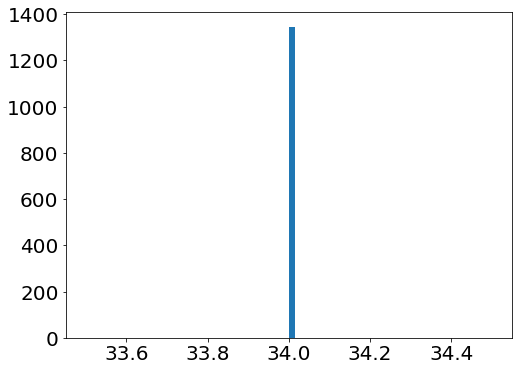

funk


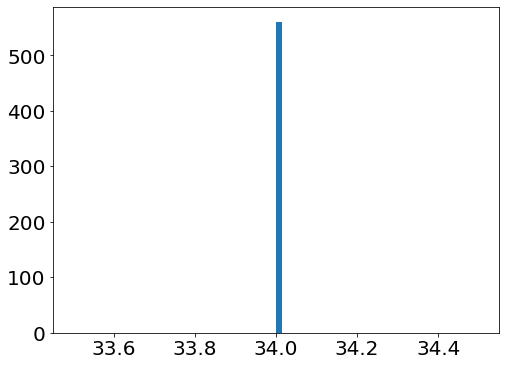

rock


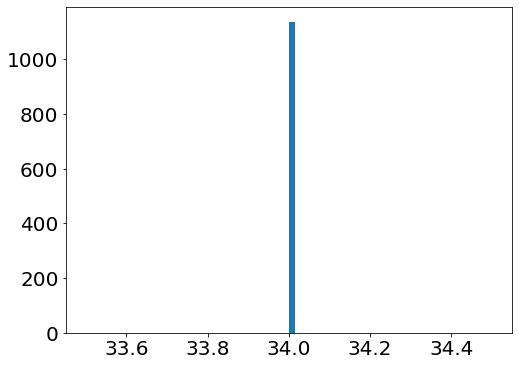

jazz


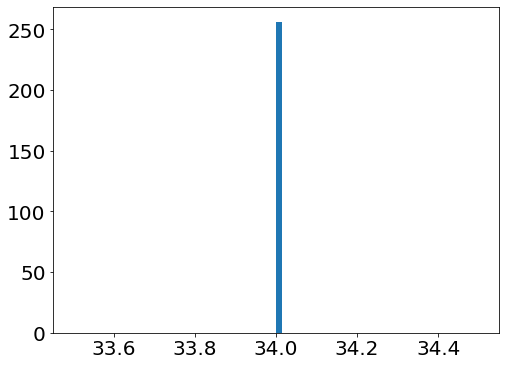

hiphop


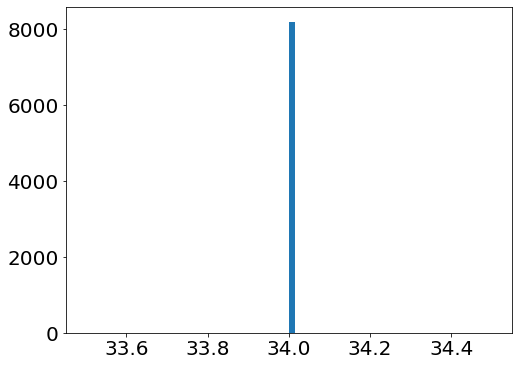

blues


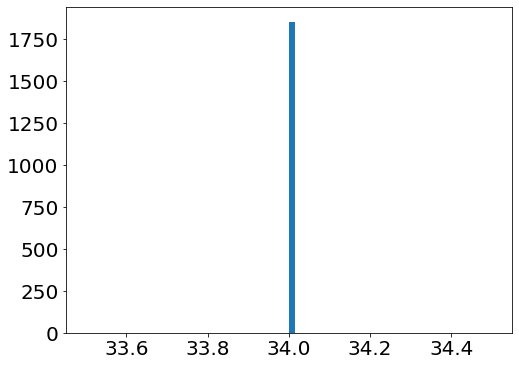

(6, 64)
['electronic', 'funk', 'rock', 'jazz', 'hiphop', 'blues']


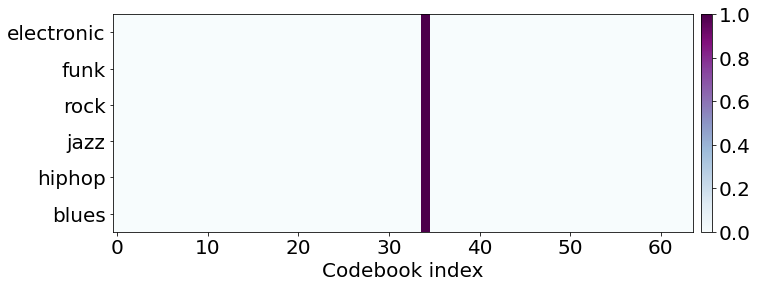

In [17]:
code_dist = np.zeros((len(GENRE_LIST),64))

plt.rcParams.update({'font.size': 20})

if model_type == "vqvae" :
    all_q_zs= batch2array(all_quantized_z)
    # all_q_zs = all_q_zs.reshape(-1)
    all_genre_idxs = np.array(all_genre_idxs).reshape(-1)
    # all_genre_idxs.shape
    
    code_dict = defaultdict()
    
    for g in range(len(GENRE_LIST)): 
        print (GENRE_LIST[g])
        curr_genre_idxs = np.where(all_genre_idxs == g)

        curr_qs = all_q_zs[curr_genre_idxs]

        curr_qs = curr_qs.reshape(-1)
        
        for q in curr_qs : 
            code_dist[g][q] += 1 
        
         
        plt.hist(curr_qs, bins=64)
        plt.show()

#     plt.hist(all_q_zs)
print (code_dist.shape)
code_dist_norm = code_dist / np.sum(code_dist, axis=1)[:, np.newaxis]

# plt.matshow(code_dist_norm, cmap="Purples")



fig, ax = plt.subplots(figsize=(30,4))
norm_data = (code_dist - np.min(code_dist, axis=1)[:, np.newaxis]) / np.ptp(code_dist, axis=1)[:, np.newaxis]
im2 = ax.imshow(norm_data, interpolation='none', cmap='BuPu', aspect=4)

im_ratio = norm_data.shape[0]/norm_data.shape[1]

fig.colorbar(im2, ax=ax, pad=0.005) #,  fraction=0.049 * im_ratio,pad=0.01) # anchor=(0.2,0.5))
ax.set_xlabel("Codebook index")
ax.set_yticks(np.arange(len(GENRE_LIST)))
ax.set_yticklabels(GENRE_LIST)

# ax.set_xticks(np.arange(64))
# ax.set_xticklabels(np.aran)
print(GENRE_LIST)
# plt.show()
# plt.savefig("codebook.png", dpi=900, bbox_inches='tight')
# plt.savefig("codebook.pdf", bbox_inches='tight')

## Plot 

In [18]:
def plot_drum_matrix(a):
    if a is not None:
        a = np.transpose(np.squeeze(a))
        plt.matshow(a)
        plt.show() 

(32, 7)


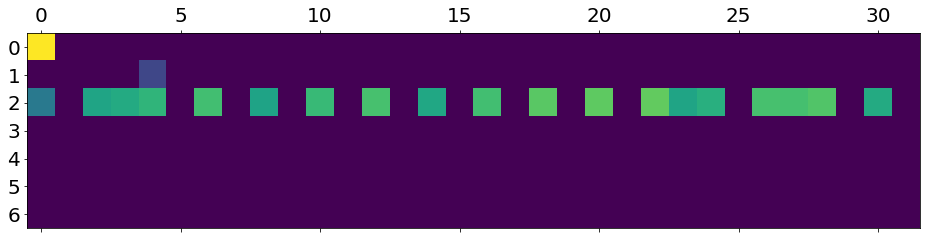

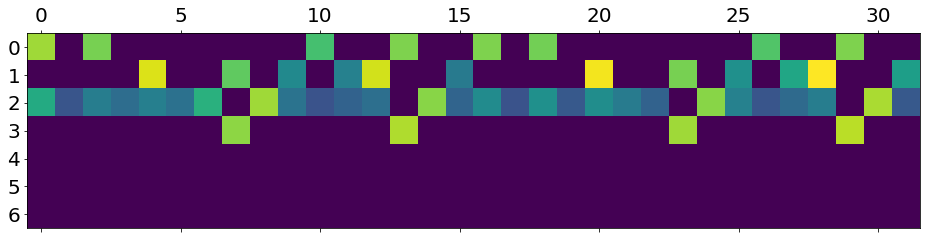

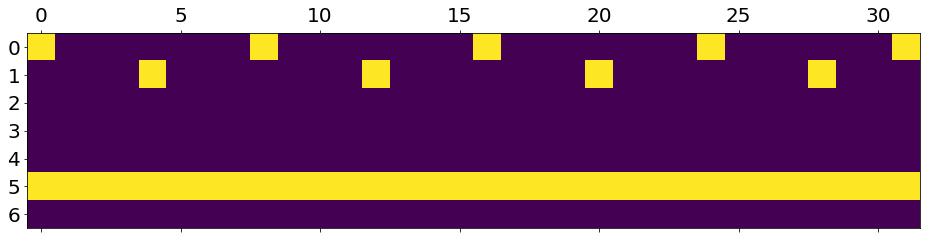

--------------------------------
(32, 7)


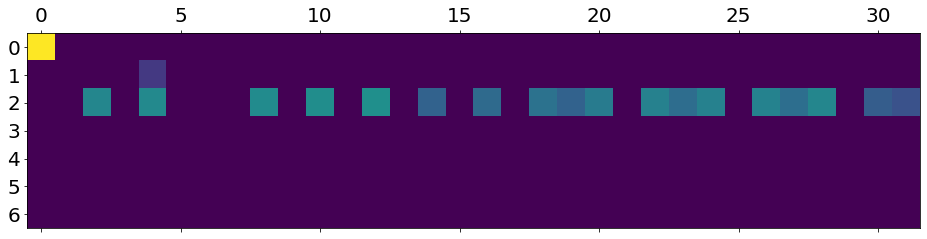

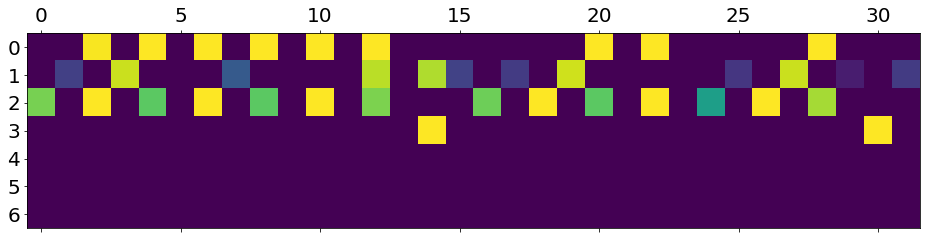

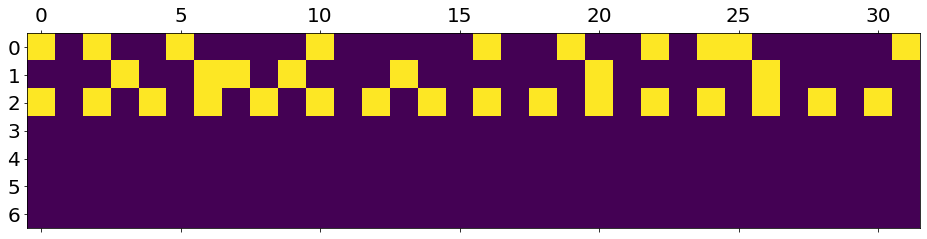

--------------------------------
(32, 7)


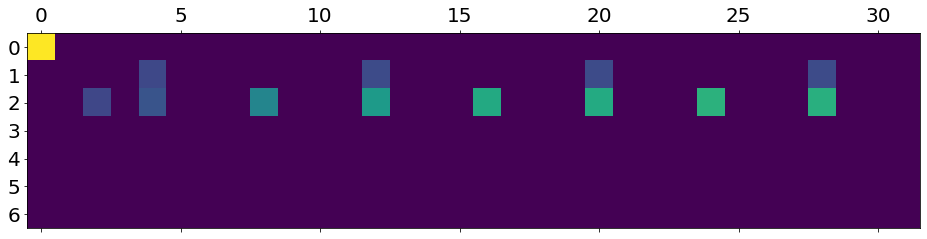

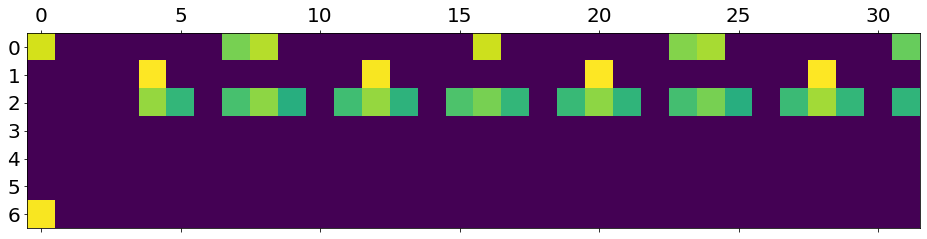

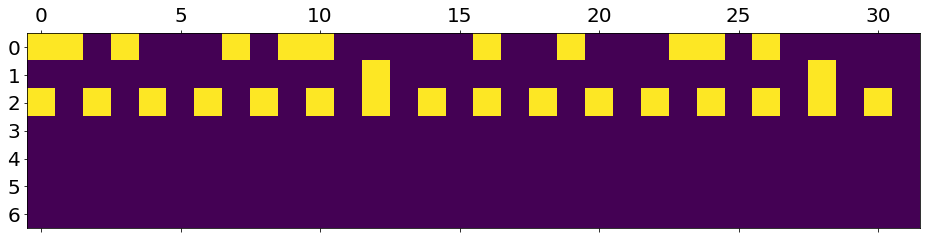

--------------------------------
(32, 7)


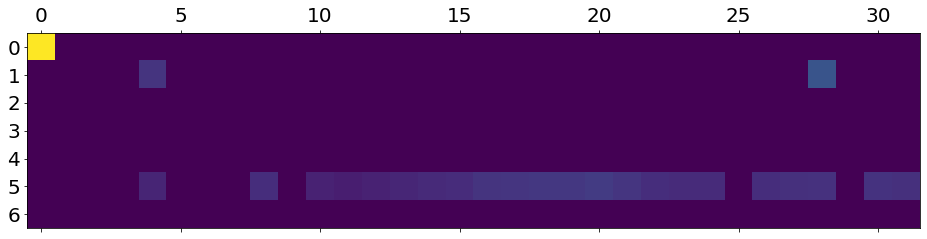

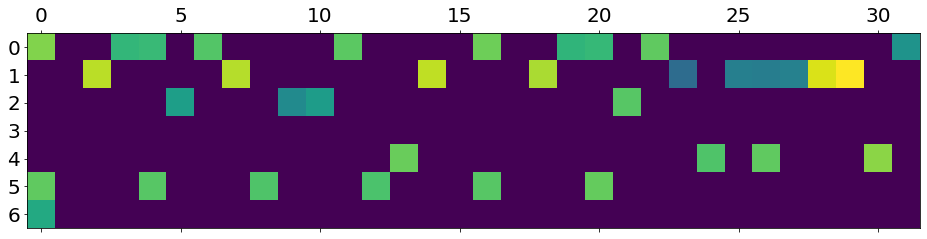

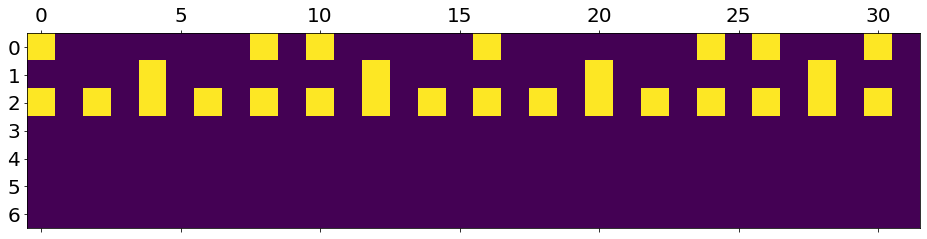

--------------------------------
(32, 7)


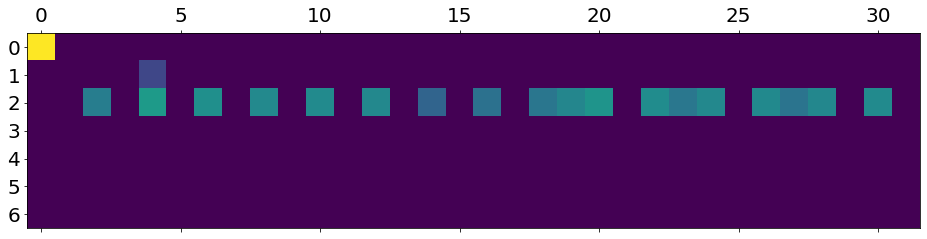

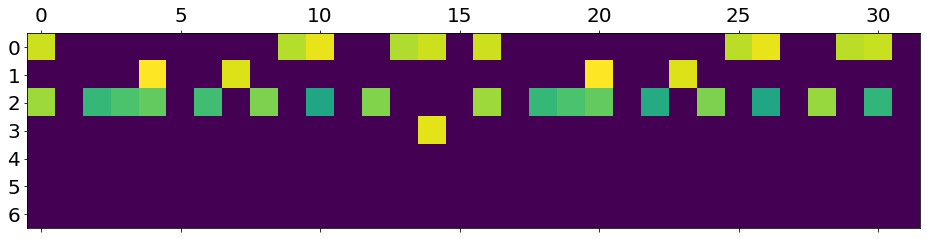

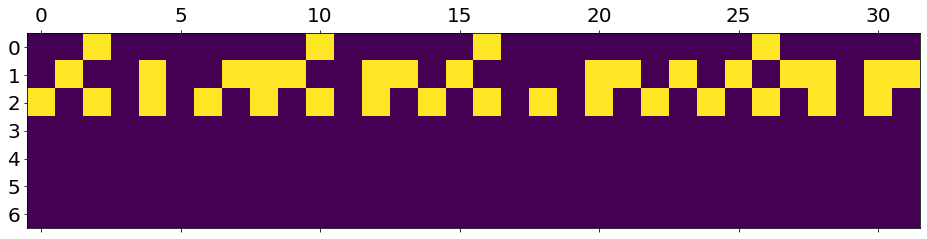

--------------------------------
(32, 7)


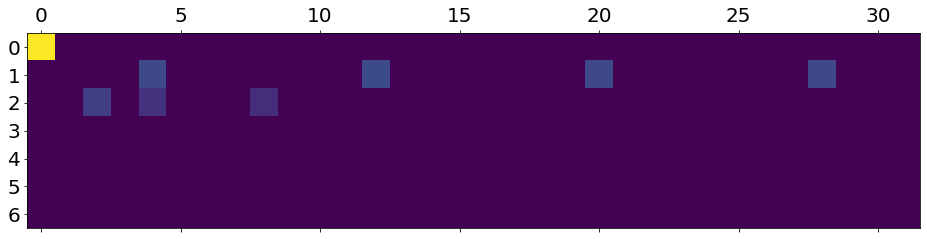

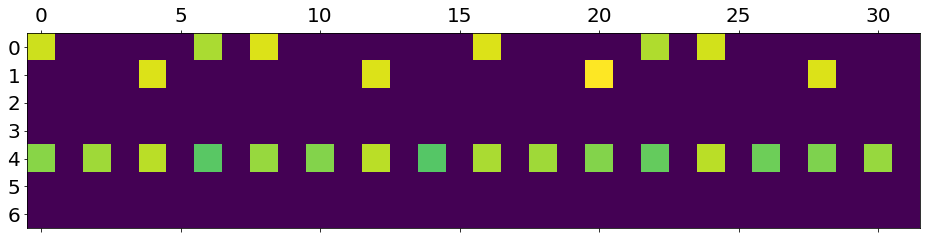

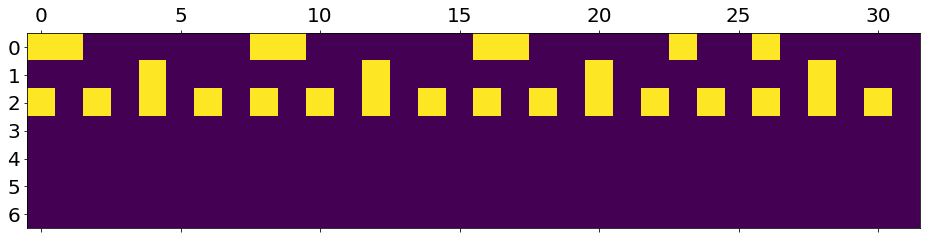

--------------------------------
(32, 7)


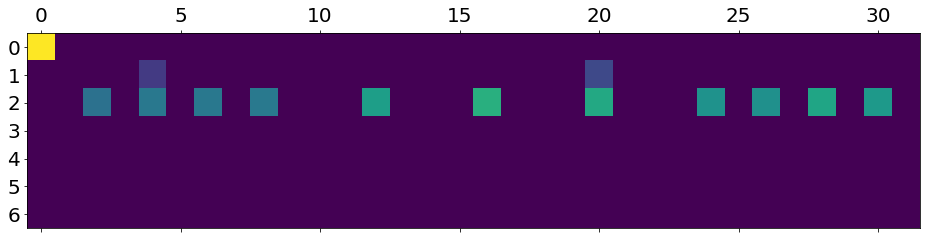

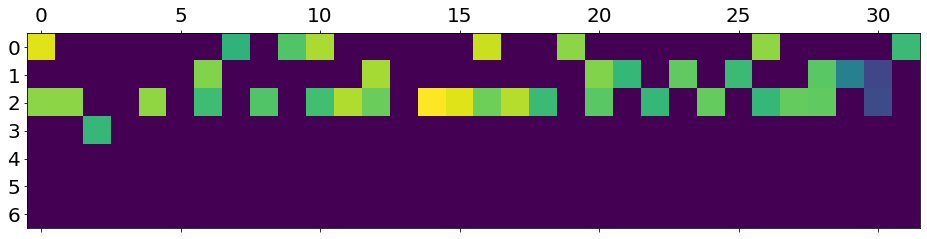

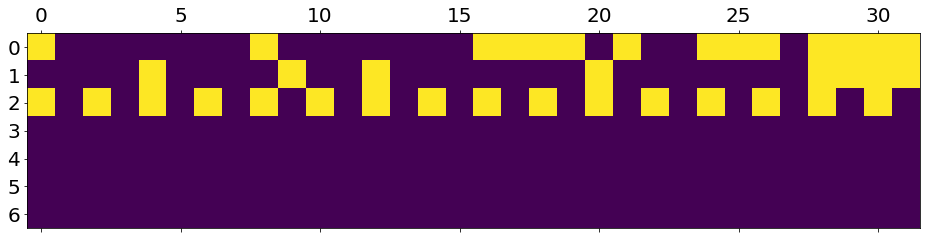

--------------------------------
(32, 7)


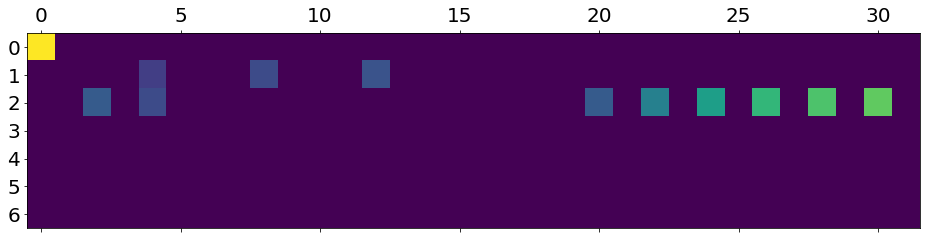

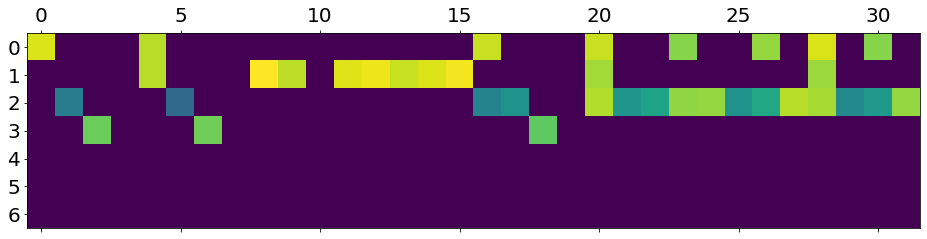

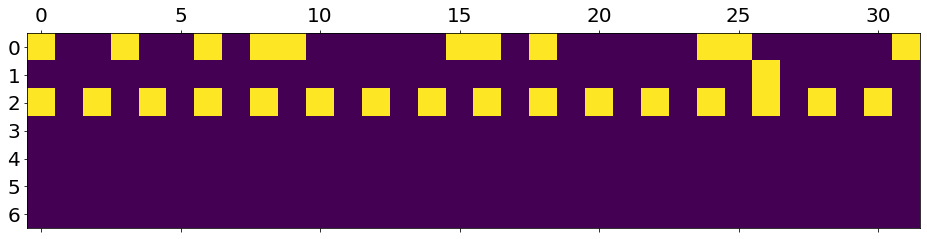

--------------------------------
(32, 7)


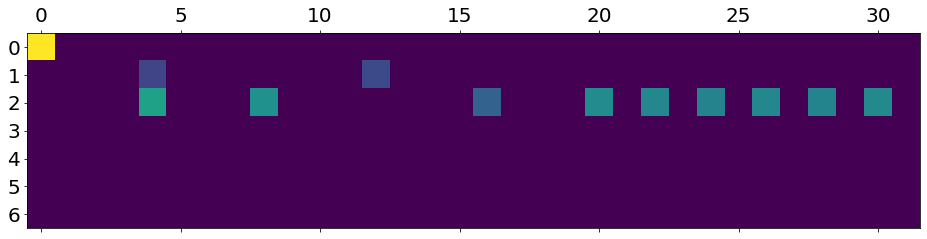

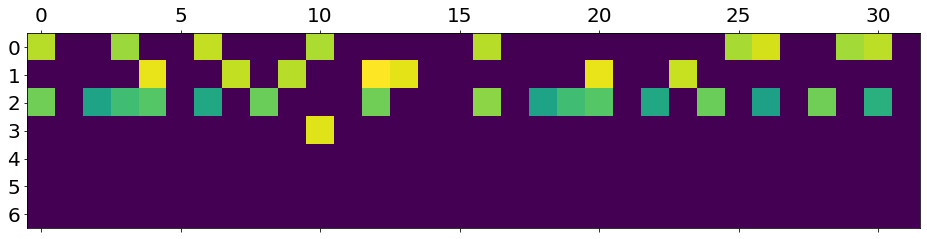

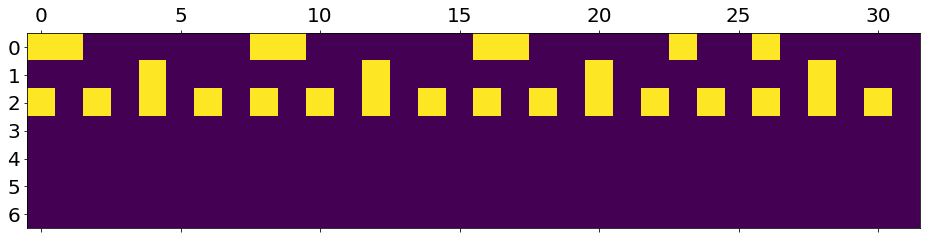

--------------------------------
(32, 7)


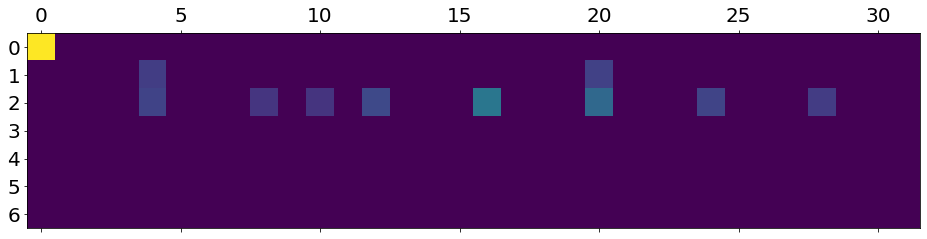

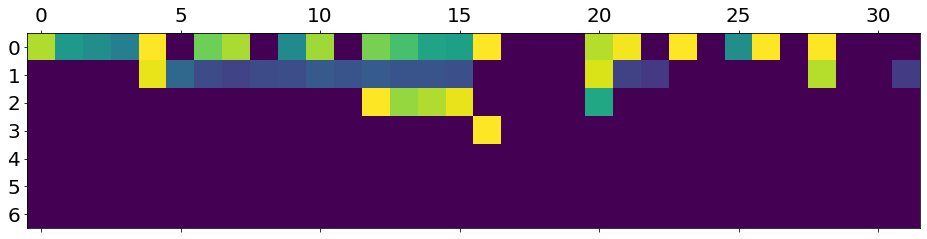

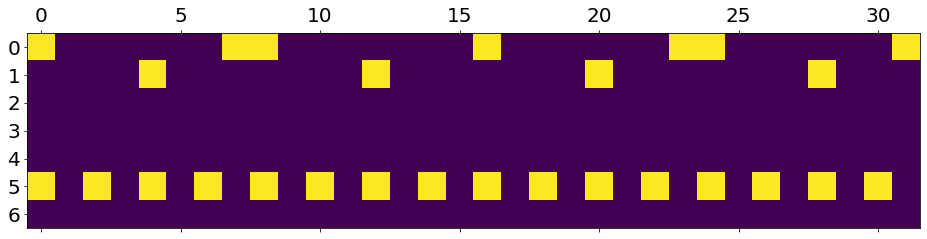

--------------------------------
(32, 7)


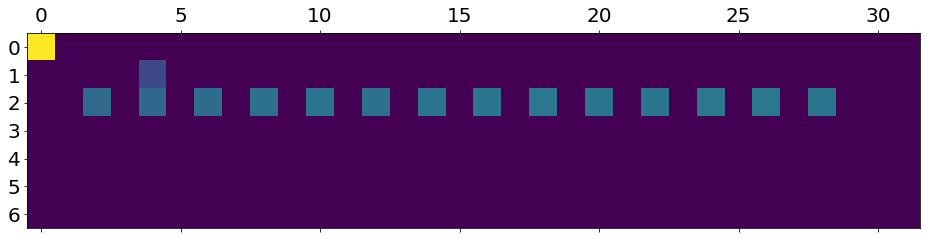

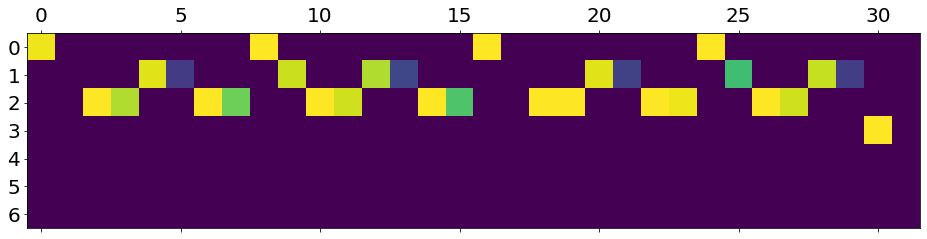

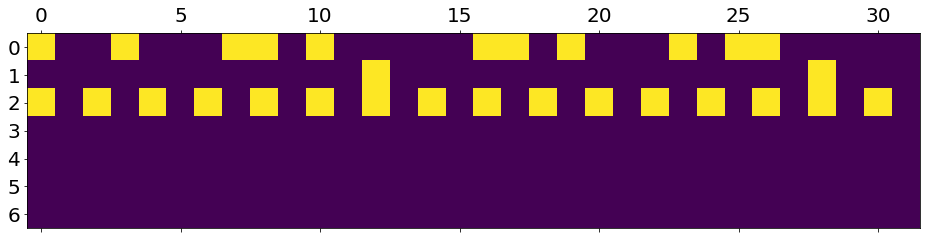

--------------------------------
(32, 7)


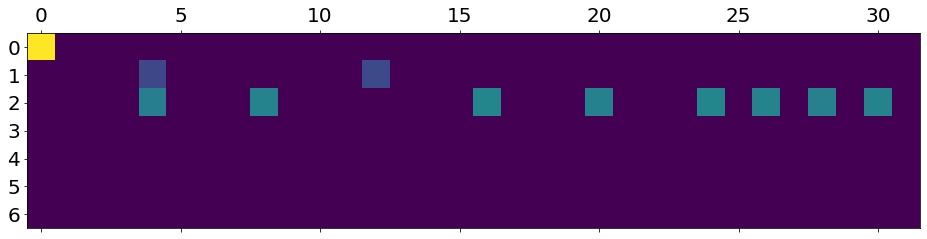

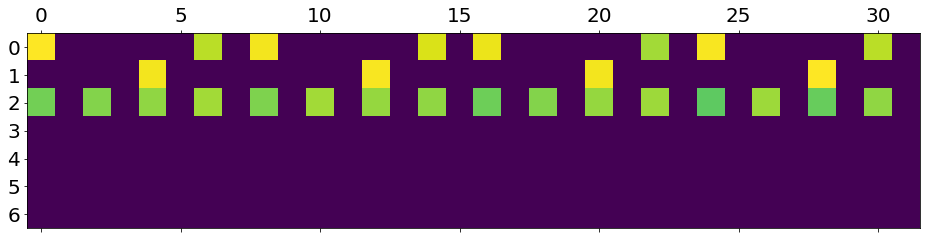

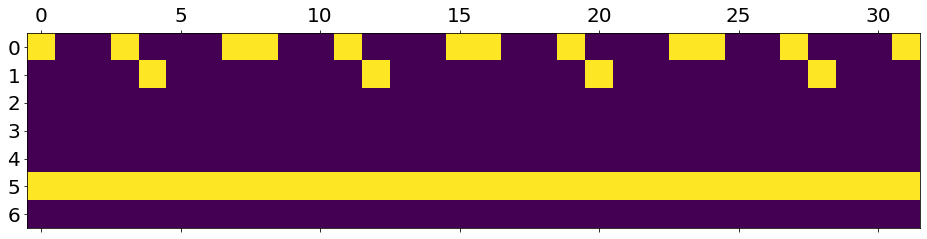

--------------------------------
(32, 7)


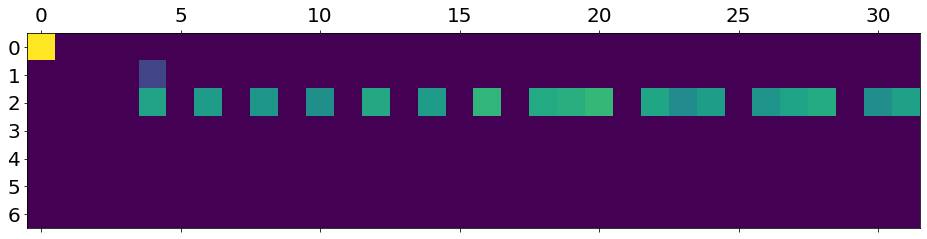

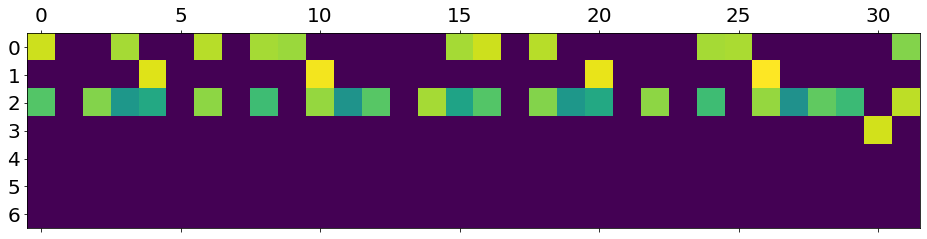

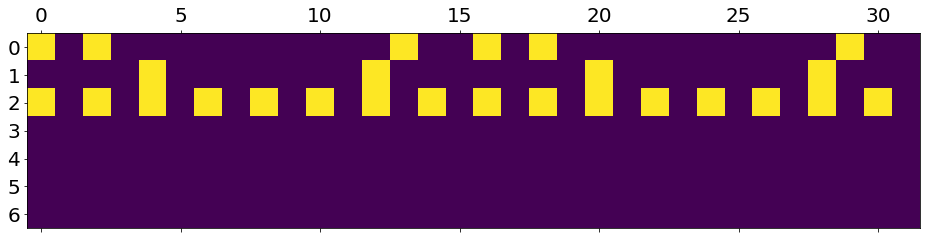

--------------------------------
(32, 7)


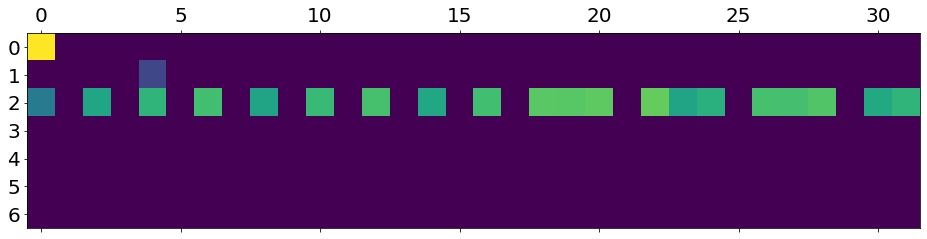

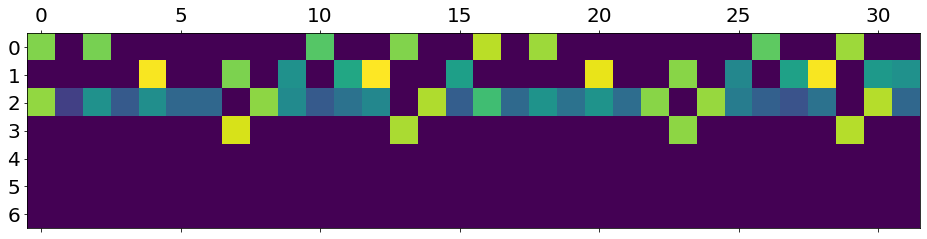

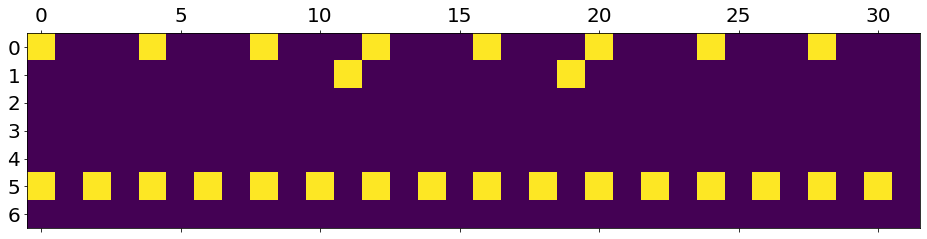

--------------------------------
(32, 7)


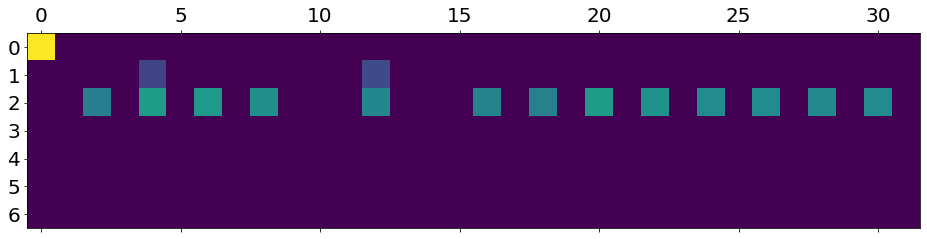

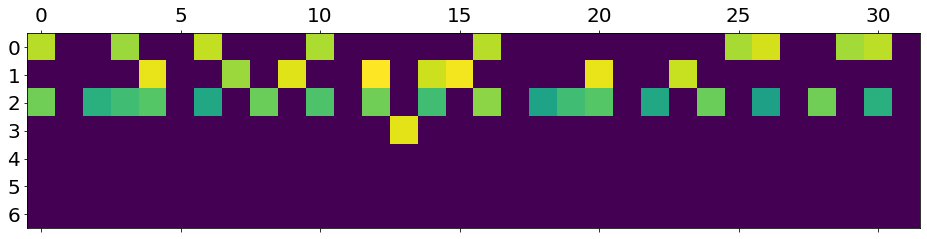

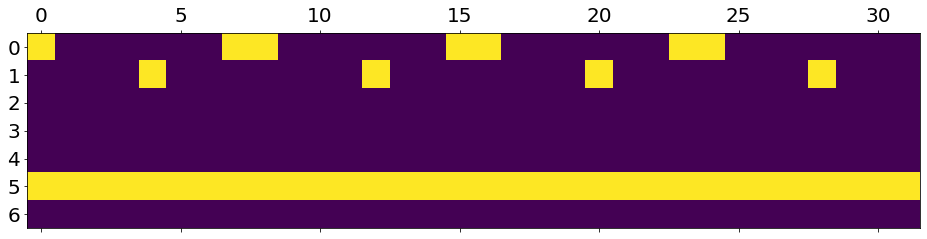

--------------------------------
(32, 7)


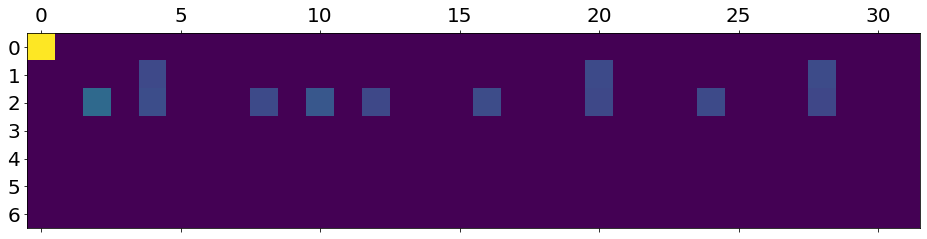

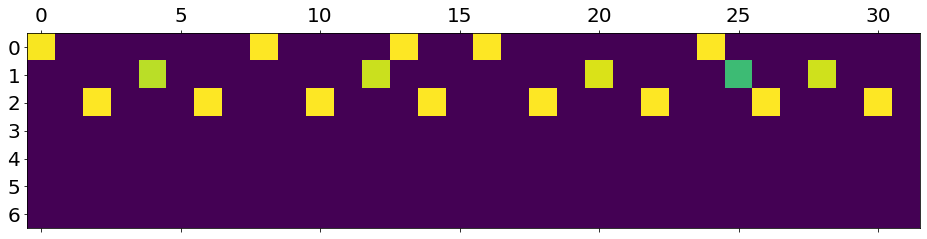

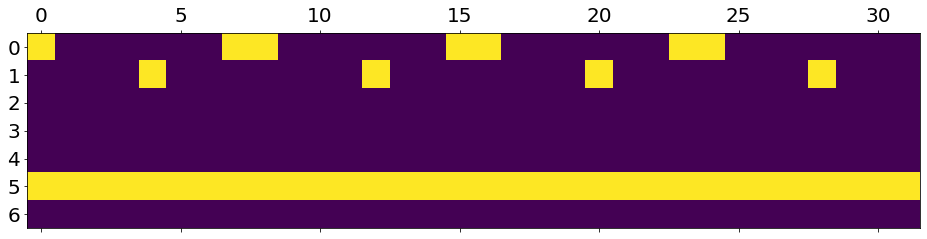

--------------------------------
(32, 7)


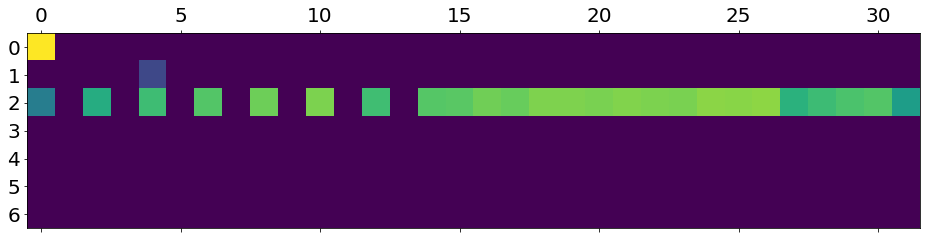

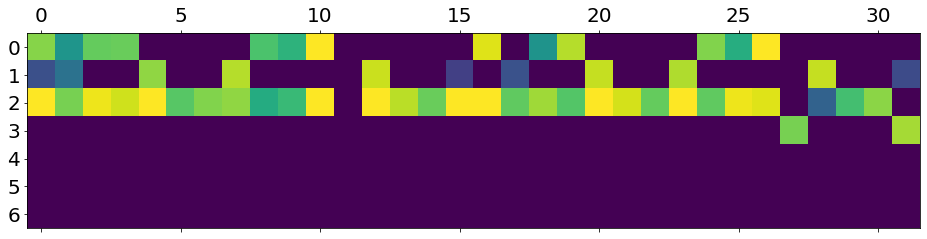

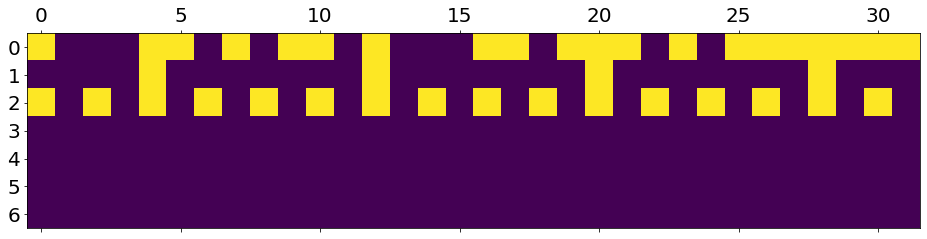

--------------------------------
(32, 7)


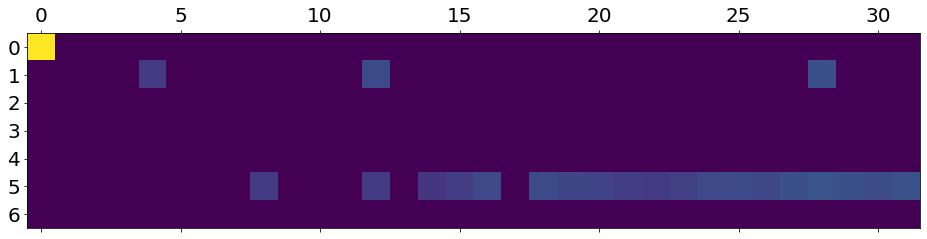

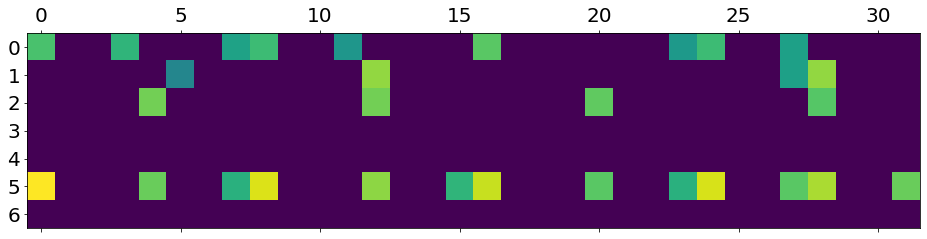

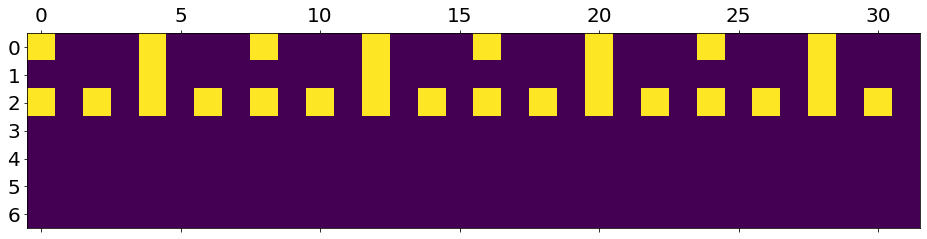

--------------------------------
(32, 7)


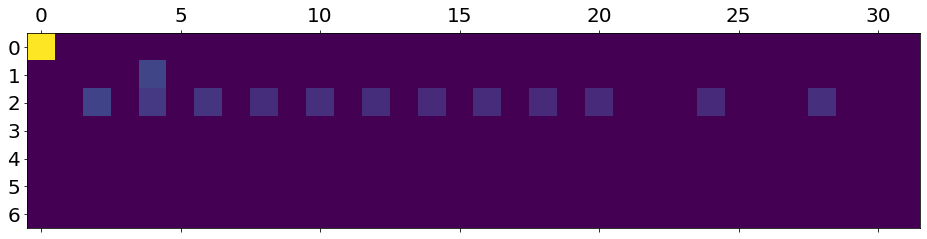

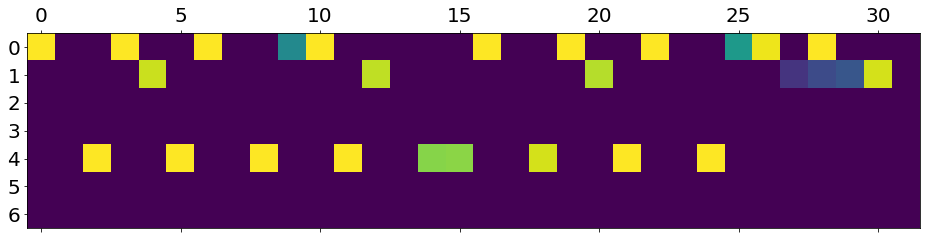

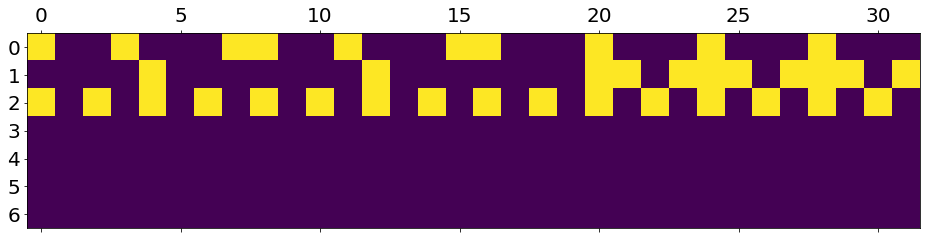

--------------------------------
(32, 7)


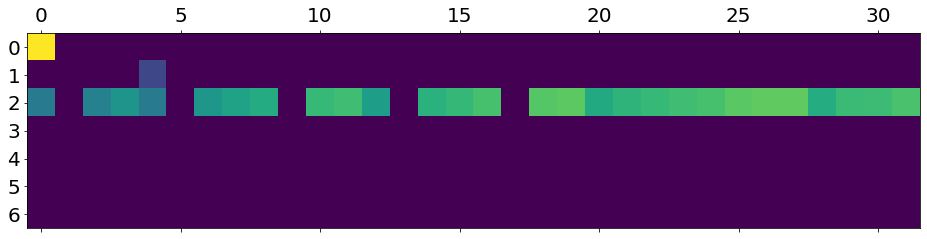

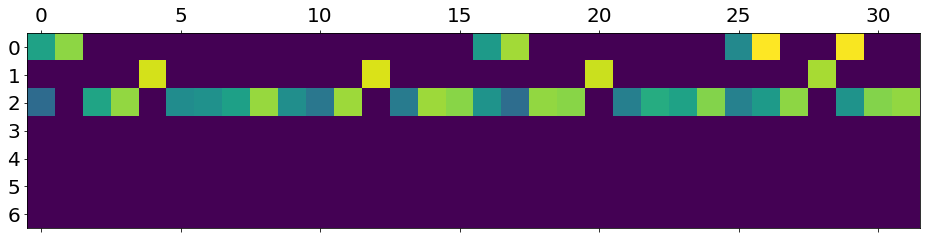

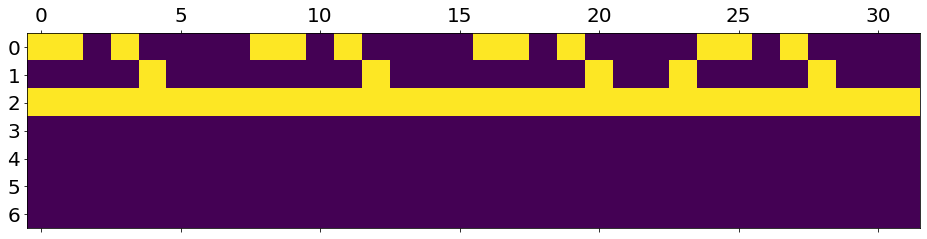

--------------------------------
(32, 7)


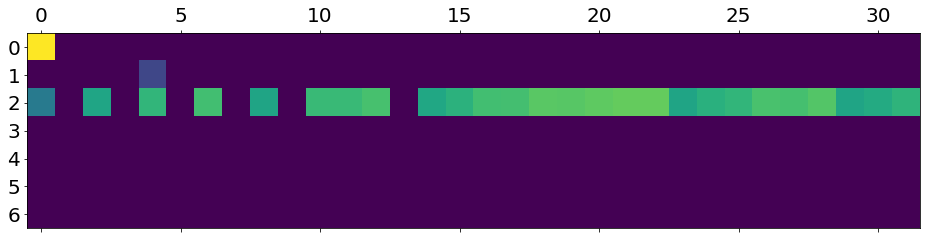

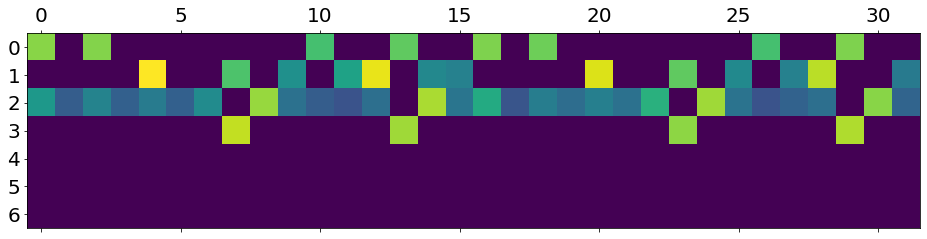

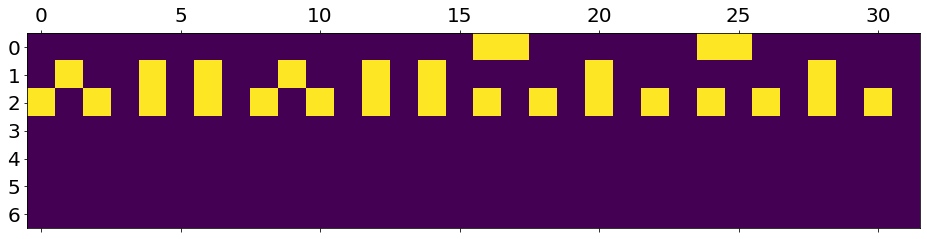

--------------------------------
(32, 7)


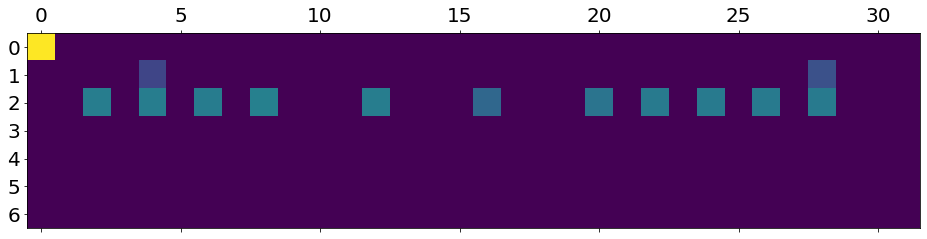

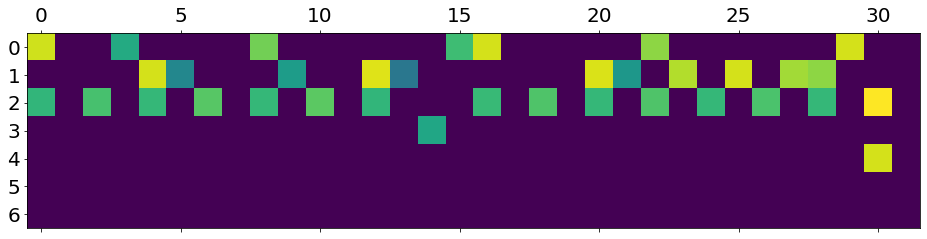

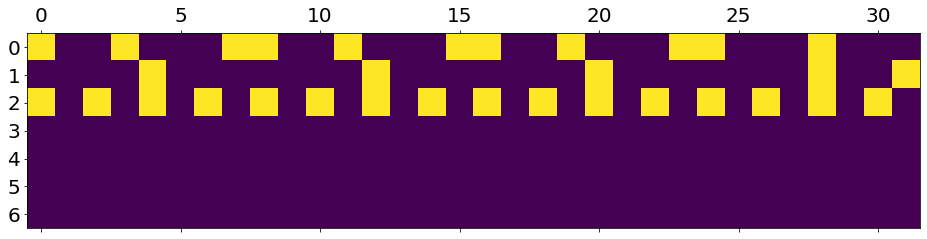

--------------------------------
(32, 7)


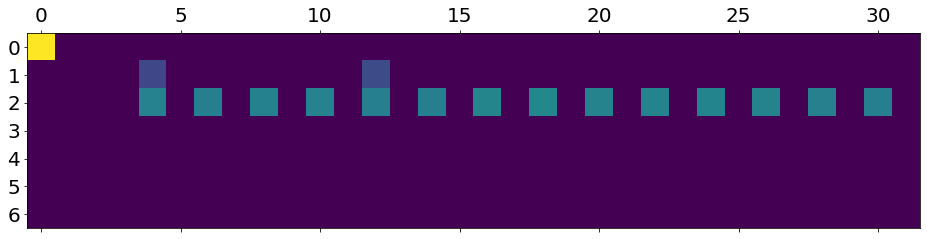

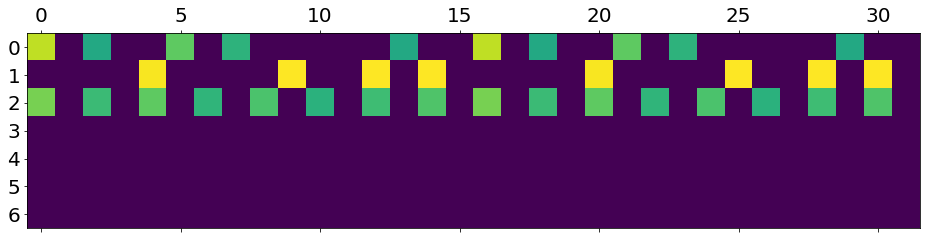

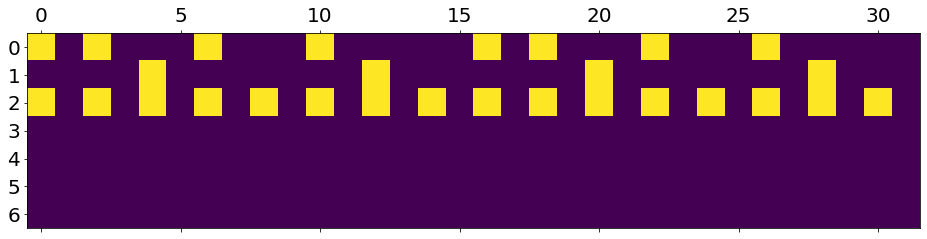

--------------------------------
(32, 7)


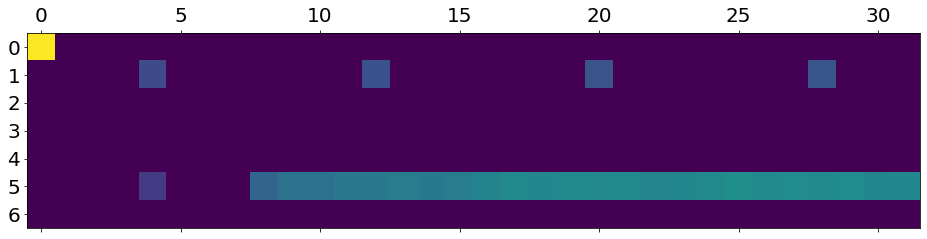

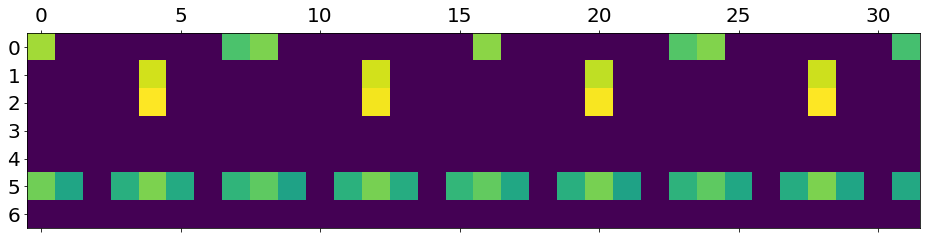

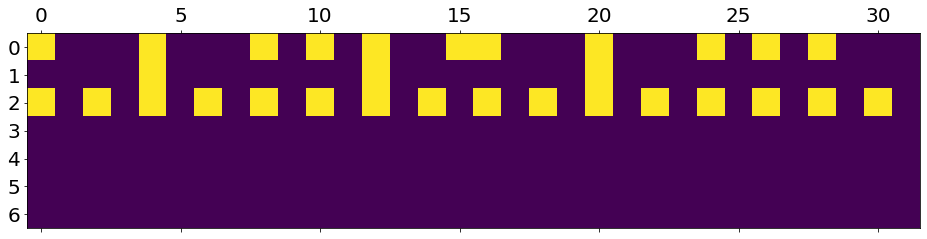

--------------------------------
(32, 7)


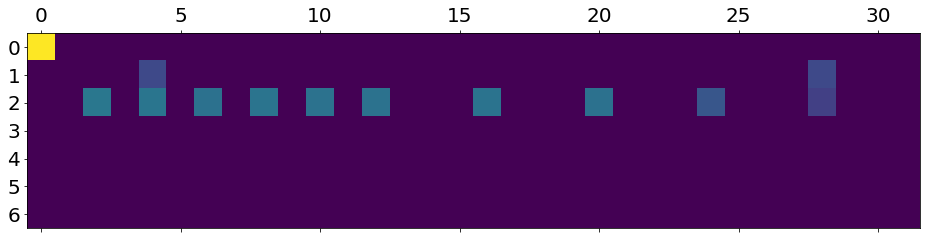

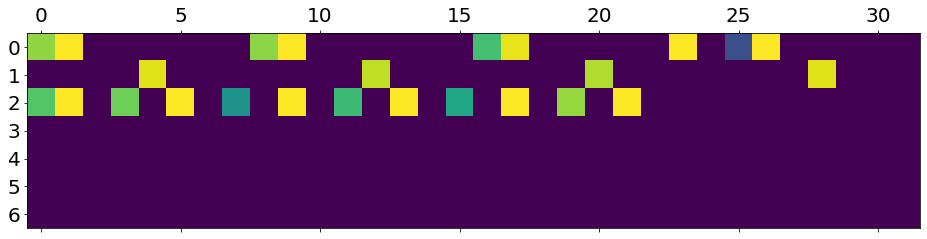

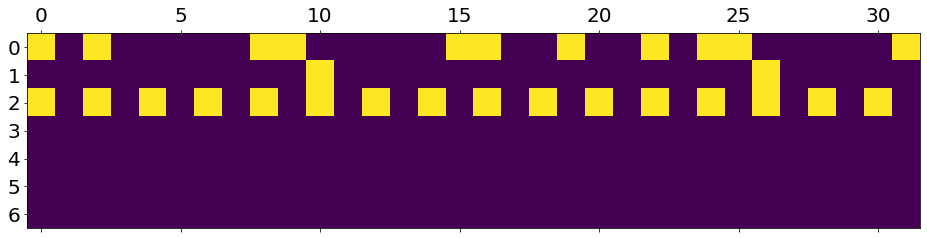

--------------------------------
(32, 7)


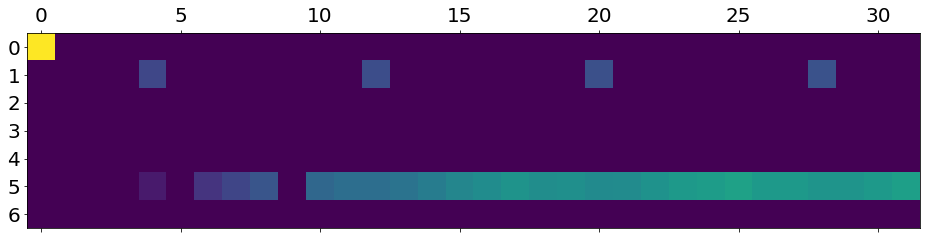

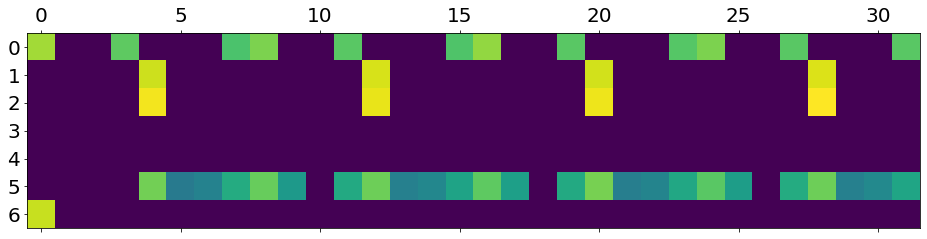

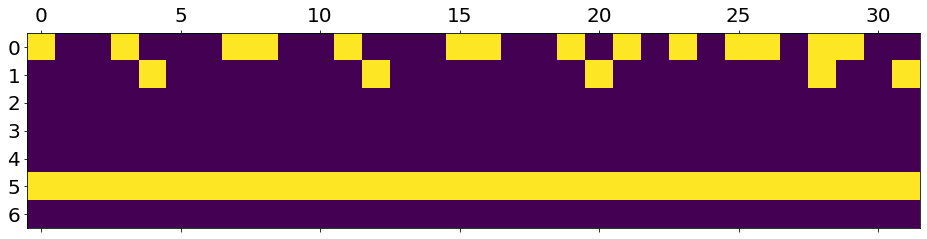

--------------------------------
(32, 7)


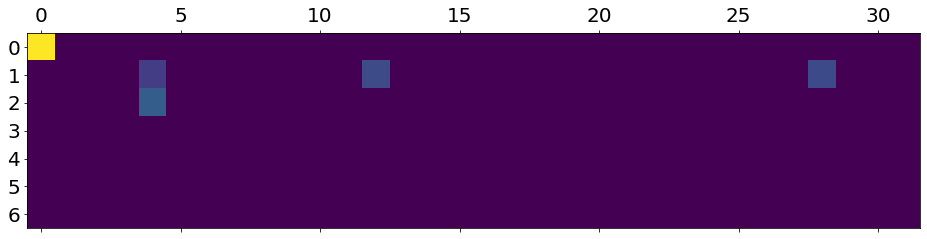

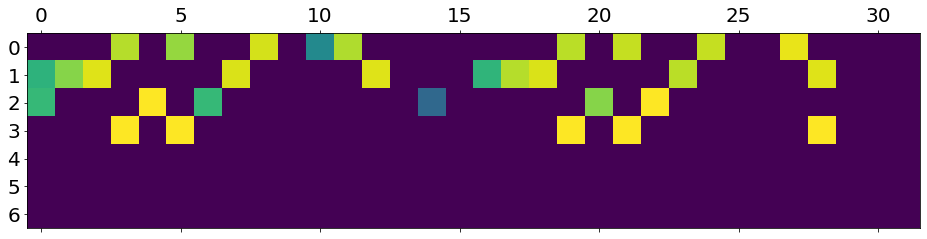

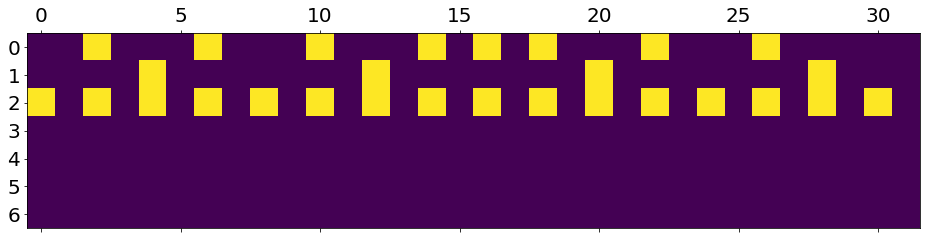

--------------------------------
(32, 7)


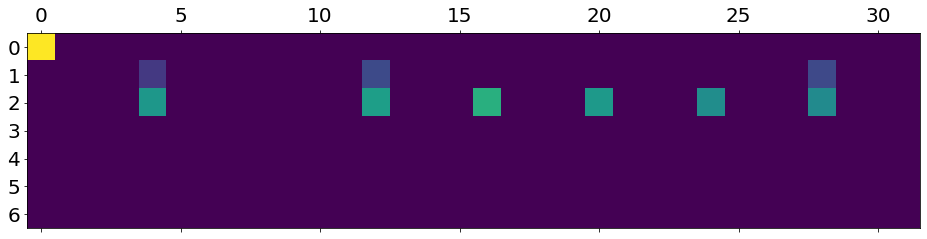

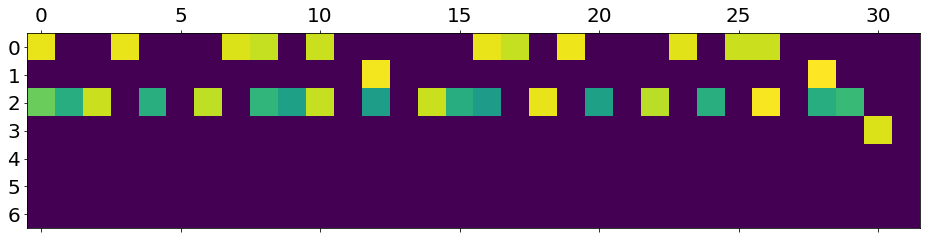

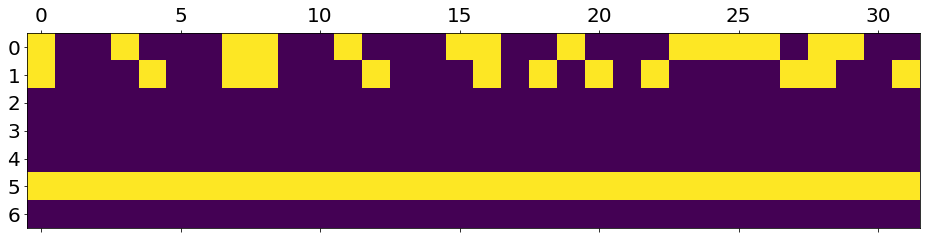

--------------------------------
(32, 7)


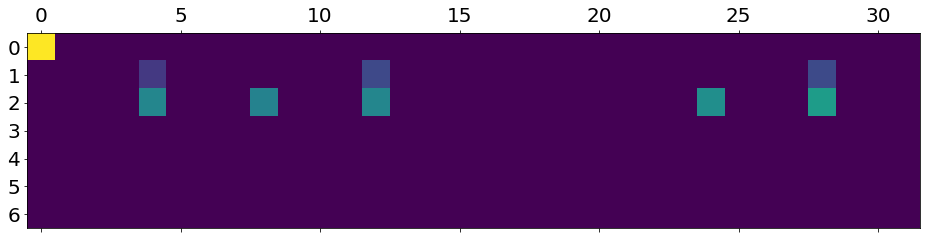

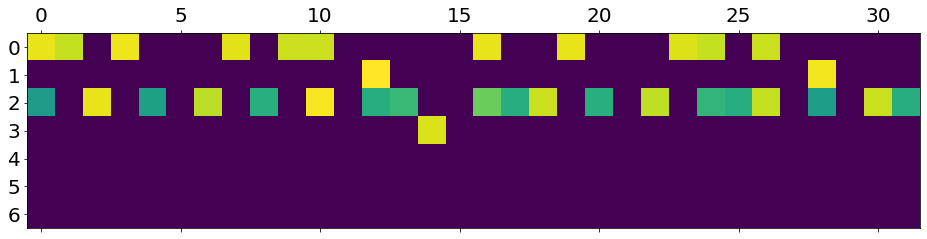

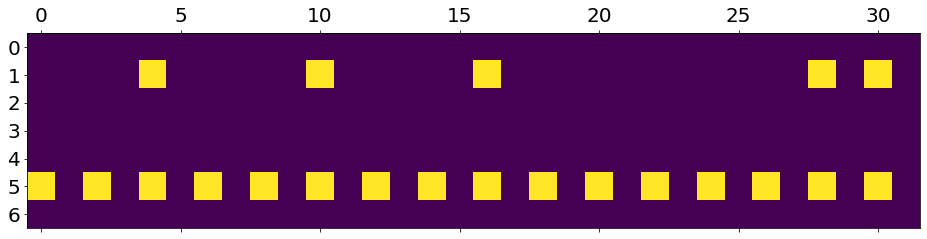

--------------------------------
(32, 7)


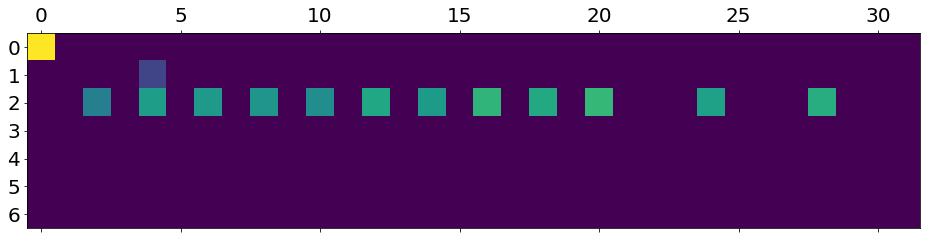

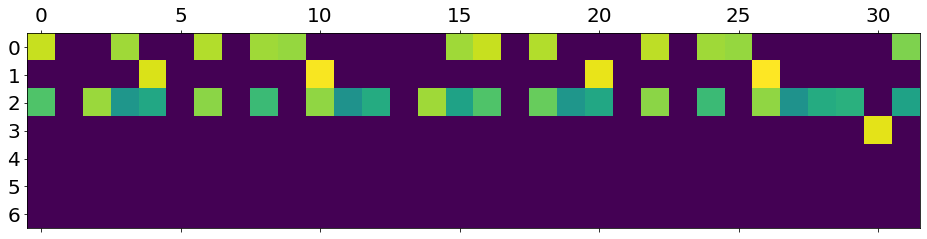

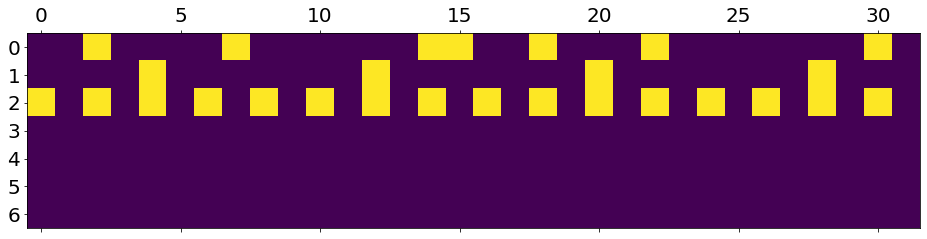

--------------------------------
(32, 7)


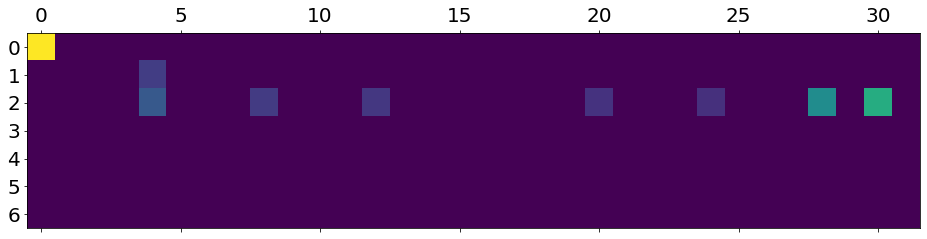

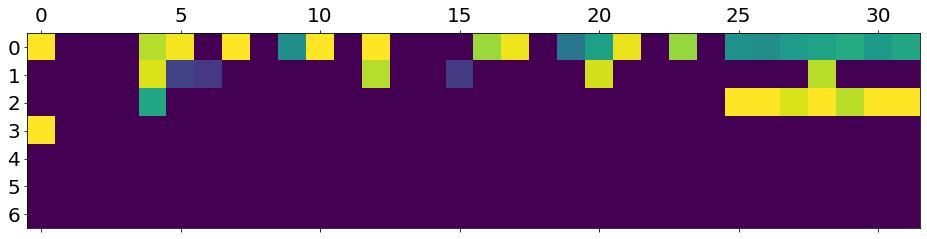

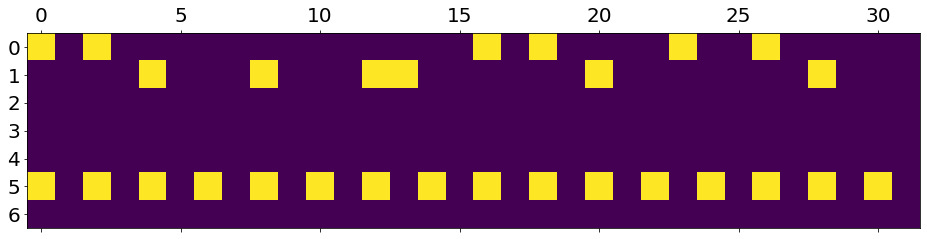

--------------------------------


In [19]:
for i in range(all_note_recons_.shape[0]):
    if i > 30 :
        break
        
    curr_note_orig = all_note_orig_[i]
    curr_vel_orig = all_vel_orig_[i]
    curr_mt_orig = all_mt_orig_[i]
    
    curr_note = all_note_recons_[i]
    curr_vel = all_vel_recons_[i] * curr_note
    curr_time = all_mt_recons_[i] * curr_note
    
    curr_skel = skels[i]
    print (curr_skel.shape)
    plot_drum_matrix(curr_vel)
    plot_drum_matrix(curr_vel_orig)
    plot_drum_matrix(curr_skel)
    print ("--------------------------------")
    # need original....